In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from time import time
from starlight.models_cy import lnprob_distbinmarg

In [2]:
from astropy.table import Table, hstack, join
import dustmaps.bayestar, dustmaps.sfd
import astropy.units as units
from astropy.coordinates import SkyCoord

In [3]:
data_tgas = Table.read('../tgas-source.fits')
data_apass = Table.read('../tgas-matched-apass-dr9.fits')
data_apass.rename_column('matched', 'matched_apass')
data_apass.rename_column('matchdist', 'matchdist_apass')
data_join = hstack((data_apass, data_tgas['source_id', 'l', 'b', 'parallax', 'parallax_error', 'phot_g_mean_mag']))
len(data_join), data_join.colnames

(2057050,
 ['ra',
  'dec',
  'bmag',
  'vmag',
  'gmag',
  'rmag',
  'imag',
  'e_bmag',
  'e_vmag',
  'e_gmag',
  'e_rmag',
  'e_imag',
  'matched_apass',
  'matchdist_apass',
  'source_id',
  'l',
  'b',
  'parallax',
  'parallax_error',
  'phot_g_mean_mag'])

In [4]:
ind = np.repeat(True, len(data_join))
ind &= data_join['matched_apass']
ind &= np.isfinite(data_join['vmag'])
ind &= np.isfinite(data_join['bmag'])
ind &= np.isfinite(data_join['parallax'])
ind &= np.isfinite(data_join['e_vmag'])
ind &= np.isfinite(data_join['e_bmag'])
ind &= np.isfinite(data_join['parallax_error'])
ind &= data_join['e_vmag'] > 0
ind &= data_join['e_bmag'] > 0
ind &= data_join['parallax_error'] > 0
ind &= (data_join['parallax'] / data_join['parallax_error'] > 1/1) # Main cut
print('Number of objects=', ind.sum())
df = data_join[ind].to_pandas()
df.describe()

/Users/bl/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


Number of objects= 1464782


,ra,dec,bmag,vmag,gmag,rmag,imag,e_bmag,e_vmag,e_gmag,e_rmag,e_imag,matchdist_apass,source_id,l,b,parallax,parallax_error,phot_g_mean_mag
count,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.453461e+06,1.427111e+06,1.372168e+06,1.464782e+06,1.464782e+06,1.453461e+06,1.427111e+06,1.372168e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06
mean,1.816695e+02,-3.101188e+00,1.206702e+01,1.133427e+01,1.169036e+01,1.116519e+01,1.103557e+01,5.475333e-02,4.379613e-02,6.267670e-02,4.169821e-02,6.969434e-02,5.392305e-05,3.646798e+18,1.892242e+02,-1.690342e+00,2.425910e+00,3.797061e-01,1.106769e+01
std,1.013317e+02,4.292381e+01,8.131927e-01,7.759872e-01,7.491655e-01,7.886966e-01,8.394411e-01,8.187632e-02,6.294040e-02,1.125786e-01,6.501273e-02,1.347890e-01,4.968288e-05,2.000933e+18,1.010618e+02,2.958069e+01,2.204461e+00,1.650950e-01,8.320954e-01
min,4.480000e-04,-8.867937e+01,6.032000e+00,5.828000e+00,6.290000e+00,5.738000e+00,4.594000e+00,1.000000e-03,1.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.627862e+12,8.787958e-04,-8.987968e+01,2.167810e-01,2.048801e-01,4.649394e+00
25%,9.941414e+01,-4.031799e+01,1.156100e+01,1.081200e+01,1.118900e+01,1.063200e+01,1.050300e+01,2.100000e-02,2.000000e-02,1.800000e-02,1.900000e-02,2.400000e-02,2.141253e-05,1.969698e+18,9.982691e+01,-1.845621e+01,1.137216e+00,2.669441e-01,1.051163e+01
50%,1.718249e+02,-5.352760e+00,1.217600e+01,1.142600e+01,1.177600e+01,1.124100e+01,1.110800e+01,3.300000e-02,3.300000e-02,3.300000e-02,3.200000e-02,4.300000e-02,3.742997e-05,3.611579e+18,1.984313e+02,-1.570938e+00,1.841779e+00,3.193105e-01,1.116613e+01
75%,2.752525e+02,3.443952e+01,1.266700e+01,1.191700e+01,1.224700e+01,1.175300e+01,1.164700e+01,5.600000e-02,5.300000e-02,6.400000e-02,5.100000e-02,7.000000e-02,6.725873e-05,5.509087e+18,2.774967e+02,1.535374e+01,2.993496e+00,4.281026e-01,1.168366e+01
max,3.599999e+02,8.867352e+01,1.728600e+01,1.539800e+01,1.830900e+01,1.746200e+01,1.773700e+01,4.936000e+00,5.191000e+00,6.850000e+00,5.577000e+00,5.884000e+00,2.777731e-04,6.917494e+18,3.599988e+02,8.989966e+01,1.205942e+02,9.999978e-01,1.569592e+01


In [5]:
bayestar = dustmaps.bayestar.BayestarQuery(max_samples=2)
sfd = dustmaps.sfd.SFDQuery()

In [186]:
nobj = int(1e4) # len(df) #
sel = np.random.choice(len(df), nobj, replace=False)

obsvarpis = df[['parallax']].values[sel, :].ravel().astype(np.double)
obsvarpis_var = df[['parallax_error']].values[sel, :].ravel().astype(np.double)**2.0

ls = df[['l']].values[sel, :].ravel().astype(np.double)
bs = df[['b']].values[sel, :].ravel().astype(np.double)
distances = (1000/obsvarpis)
coords = SkyCoord(ls*units.deg, bs*units.deg, distance=distances*units.pc, frame='galactic')
ras, decs = coords.icrs.ra.rad, coords.icrs.dec.rad
ebv = bayestar(coords, mode='median')
ebv2 = sfd(coords)
ind2 = ~np.isfinite(ebv)
ebv[ind2] = 0 #ebv2[ind2]

B_RedCoeff = 3.626
V_RedCoeff = 2.742

obsmags = df[['vmag']].values[sel, :].astype(np.double).ravel() 
obsmags_var = df[['e_vmag']].values[sel, :].astype(np.double).ravel() ** 2.0
obscolors = df[['bmag']].values[sel, :].astype(np.double).ravel() - obsmags
obscolors_var = df[['e_bmag']].values[sel, :].astype(np.double).ravel()**2.0 + obsmags_var

dustamps = ebv.astype(np.double)
dustcoefs = np.array([V_RedCoeff, B_RedCoeff - V_RedCoeff])
    
obsabsmags = obsmags + 5*np.log10(obsvarpis) - 10
obsabsmagG = df[['phot_g_mean_mag']].values[sel, :].astype(np.double).ravel() + 5*np.log10(obsvarpis) - 10
obsabsmag.min(), obsabsmag.max(), obscolors.min(), obscolors.max()
varpimagvar = (obsvarpis_var**0.5 * 5 / obsvarpis / np.log(10))**2.0

# Save the data to numpy arrays since we will run polychord outside of this notebook.
np.savez("data", obsvarpis=obsvarpis, obsvarpis_var=obsvarpis_var, 
         obsmags=obsmags, obsmags_var=obsmags_var, 
         obscolors=obscolors, obscolors_var=obscolors_var,
         dustamps=dustamps, dustcoefs=dustcoefs)    

/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median for 3304 results
  r = func(a, **kwargs)


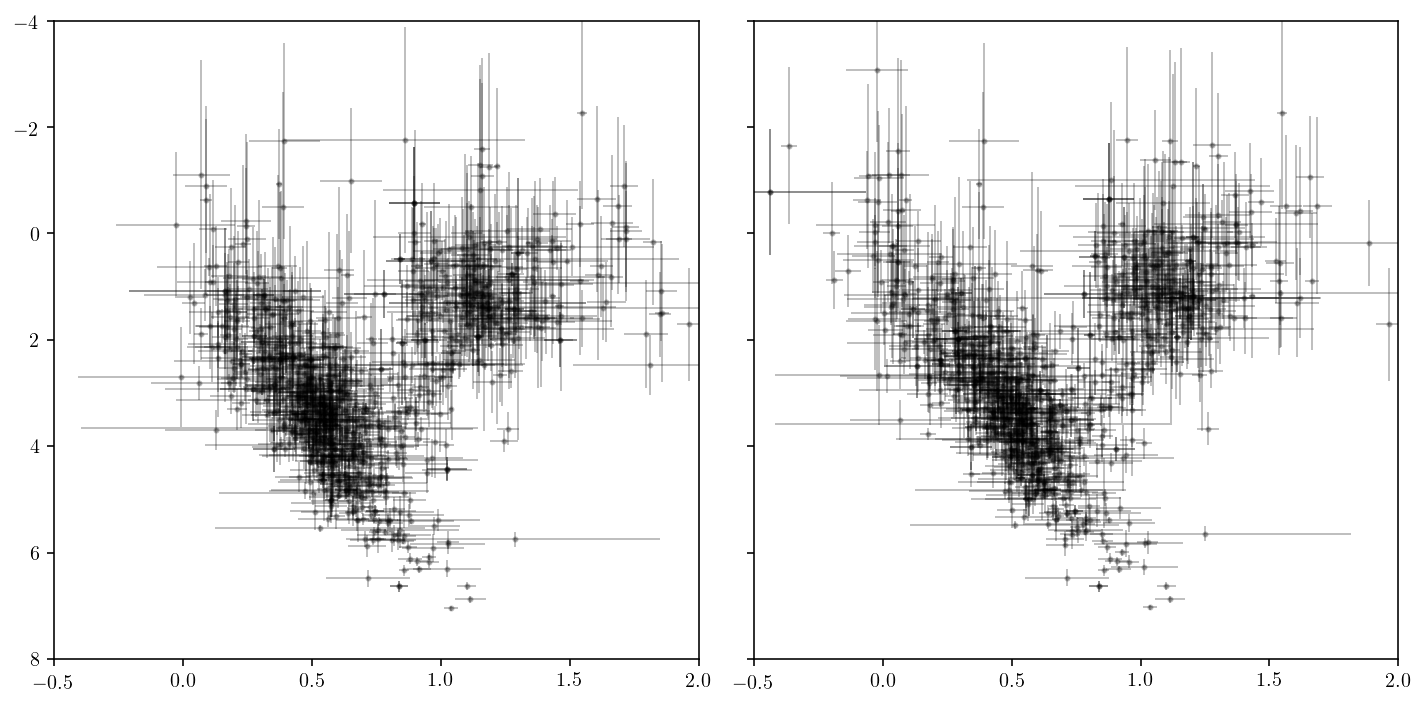

In [256]:
subsel = np.random.choice(nobj, int(1e3))
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
rr = [[-0.5, 2], [-4, 8]]
for i in range(1):
    axs[0].errorbar(obscolors[subsel], 
                      obsabsmags[subsel], 
                      xerr=obscolors_var[subsel]**0.5,
                      yerr=(obsmags_var[subsel] + varpimagvar[subsel])**0.5,
                      markersize=2, alpha=0.25, fmt="o", lw=1)
    axs[1].errorbar(obscolors[subsel] - dustamps[subsel] * dustcoefs[i+1], 
                      obsabsmags[subsel] - dustamps[subsel] * dustcoefs[0], 
                      xerr=obscolors_var[subsel]**0.5,
                      yerr=(obsmags_var[subsel] + varpimagvar[subsel])**0.5,
                      markersize=2, alpha=0.25, fmt="o", lw=1)
    for j in range(2):
        axs[j].set_ylim(rr[1][::-1])
        axs[j].set_xlim(rr[0])
fig.tight_layout()

In [247]:

code1 = """

import numpy as np
import sys
sys.path.append('/Users/bl/Dropbox/software/PolyChord') # Put correct path here.
import PyPolyChord.PyPolyChord_wrapper as PolyChord

from starlight.models_cy import lnprob_distbinmarg

nderived = 0

nbins = 5
sigma = 3.0
nmarggrid = 5
 
data = np.load("data.npz")
nobj = data["obsvarpis"].size
ndim = nbins-1 + 2*nbins + 2*nbins + nbins 

def transform(x, xmin, xmax):
    n = len(x)
    t = [0] * n
    t[n-1] = x[n-1]**(1./n)
    for i in range(n-2,-1,-1):
        t[i] = x[i]**(1./(i+1)) * t[i+1]
    return [xmin + (xmax - xmin) * t[i] for i in range(n)]

def prior(cube):
    theta = [0.0] * ndim
    for i in range(nbins):
        theta[i] = cube[i]
        theta[nbins-1+i] = -2 + 10*cube[nbins-1+i]
        theta[3*nbins-1+i] = 0.1 + 3*cube[3*nbins-1+i]
        theta[4*nbins-1+i] = 0.1 + 3*cube[4*nbins-1+i]
        theta[5*nbins-1+i] = -1 + 2*cube[5*nbins-1+i]
    theta[2*nbins-1:3*nbins-1] = transform(cube[2*nbins-1:3*nbins-1], 0, 2)
    return theta


def mixturemodellnprob(inparams):

    phi = [0.0] * 0
    params = np.array(inparams)
    zs = params[0:nbins-1]
    binmus = params[nbins-1:3*nbins-1].reshape((2, nbins)).T
    binvars = params[3*nbins-1:5*nbins-1].reshape((2, nbins)).T**2.0
    binrhos = params[5*nbins-1:6*nbins-1].reshape((nbins, 1))
    fac = np.array([1.0]*nbins)
    zsb = np.array([1.0]*nbins)
    for i in range(nbins-1):
        fac[i] = 1. - zs[i]
        zsb[i+1] = zs[i]
    binamps = np.cumprod(zsb) * fac
    
    logL = lnprob_distbinmarg(
        nobj, nbins, nmarggrid, sigma,
        data["obsvarpis"], data["obsvarpis_var"], 
        data["obsmags"], data["obsmags_var"], 
        data["obscolors"], data["obscolors_var"],
        data["dustamps"], data["dustcoefs"],
        binamps, 
        binmus, 
        binvars, 
        binrhos
    )

    return logL, phi

"""
code2 = """
PolyChord.run_nested_sampling(mixturemodellnprob, ndim, nderived, prior=prior,
                              file_root='mixturemodellnprob', do_clustering=False,
                              nlive=10*ndim, update_files=10*ndim,
                              num_repeats=10, boost_posterior=2)
"""

text_file = open("run_PyPolyChord.py", "w")
text_file.write(code1 + code2 )
text_file.close()

# go in the terminal and run
# rm -rf chains ; mkdir chains ; mkdir chains/clusters ; python run_PyPolyChord.py
# If you get a segmentation fault, you'll need to compile PolyChord with extra flags
# to make sure the stack size is sufficient.

In [33]:
nbins = 1
binamps = np.repeat(1./nbins, nbins)
binmus = np.vstack((np.random.uniform(0, 6, nbins), np.random.uniform(0, 2, nbins))).T
binvars = np.vstack((np.random.uniform(0.1, 1.2, nbins), np.random.uniform(0.1, 0.5, nbins))).T ** 2.0
binrhos = np.random.uniform(-1, 1, nbins)[:, None]
angles = np.rad2deg(np.arccos(binrhos))
print(binmus.shape, binrhos, binvars.shape)

nmarggrid = 5
sigma = 3.0

print(nobj, nbins, nmarggrid, sigma)
t1 = time()
v1 = lnprob_distbinmarg(
    nobj, nbins, nmarggrid, sigma,
    obsvarpis, obsvarpis_var, obsmags, obsmags_var, 
    obscolors, obscolors_var,
    dustamps, dustcoefs,
    binamps, 
    binmus, 
    binvars, 
    binrhos
)
t2 = time()
print(v1, t2-t1)


(1, 2) [[ 0.74230045]] (1, 2)
10000 1 5 3.0
-159671.33735392796 0.0016651153564453125


In [409]:
nbins = 5
nmarggrid = 5
sigma = 3.0
ndim = nbins - 1 + 2*nbins + 2*nbins + nbins 

def transform(x, xmin, xmax):
    n = len(x)
    t = [0] * n
    t[n-1] = x[n-1]**(1./n)
    for i in range(n-2,-1,-1):
        t[i] = x[i]**(1./(i+1)) * t[i+1]
    return [xmin + (xmax - xmin) * t[i] for i in range(n)]

def prior(cube):
    theta = [0.0] * ndim
    for i in range(nbins):
        theta[i] = cube[i]
        theta[nbins-1+i] = -2 + 10*cube[nbins-1+i]
        theta[3*nbins-1+i] = 0.1 + 3*cube[3*nbins-1+i]
        theta[4*nbins-1+i] = 0.1 + 3*cube[4*nbins-1+i]
        theta[5*nbins-1+i] = -1 + 2*cube[5*nbins-1+i]
    theta[2*nbins-1:3*nbins-1] = transform(cube[2*nbins-1:3*nbins-1], 0, 2)
    return np.array(theta)


def convert_params(params):
    zs = params[0:nbins-1]
    binmus = params[nbins-1:3*nbins-1].reshape((2, nbins)).T
    binvars = params[3*nbins-1:5*nbins-1].reshape((2, nbins)).T**2.0
    binrhos = params[5*nbins-1:6*nbins-1].reshape((nbins, 1))
    fac = np.array([1.0]*nbins)
    zsb = np.array([1.0]*nbins)
    for i in range(nbins-1):
        fac[i] = 1. - zs[i]
        zsb[i+1] = zs[i]
    binamps = np.cumprod(zsb) * fac
    return binamps, binmus, binvars, binrhos

cube = np.random.uniform(0, 1, size=ndim)
mixturemodellnprob(prior(cube))

(array([-41216.00543668]), [])

In [410]:
# Reading nested sampling outputs
samples = np.genfromtxt('/Users/bl/Dropbox/repos/Starlight/notebooks/chains/mixturemodellnprob.txt')
pos = np.argmin(samples[:, 1])
binamps, binmus, binvars, binrhos = convert_params(samples[pos, 2:])

ValueError: cannot reshape array of size 3 into shape (2,5)

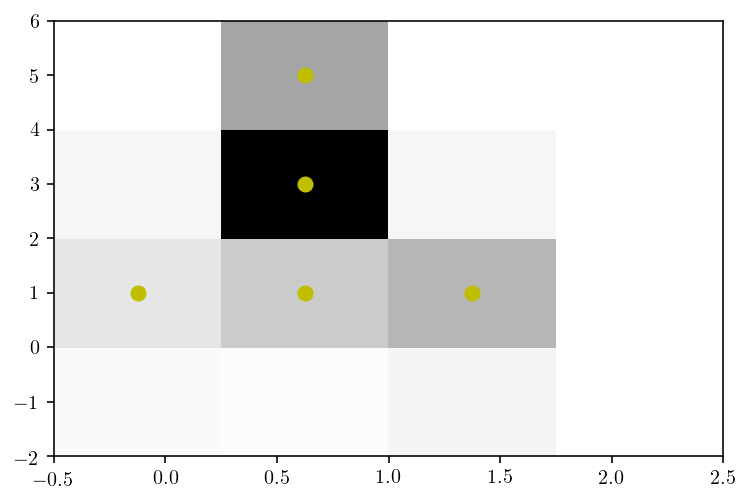

In [411]:
#tile space. 
mus_grid_1 = np.linspace(-2, 6, 5)
mus_grid_2 = np.linspace(-0.5, 2.5, 5)
mus_tiling = np.meshgrid(mus_grid_1[:-1] + (mus_grid_1[1]-mus_grid_1[0])/2., 
                        mus_grid_2[:-1] + (mus_grid_2[1]-mus_grid_2[0])/2.)
#keep nbins with highest number of objects.
#put binmus in them.
hist, _, _ = np.histogram2d(obsabsmags - dustamps * dustcoefs[0], 
                            obscolors - dustamps * dustcoefs[1], 
                            bins=[mus_grid_1, mus_grid_2])
plt.pcolormesh(mus_grid_2, mus_grid_1, hist, cmap="Greys")

sel = np.argsort(hist.T.ravel())[-nbins:]
#mus_tiling_flat = mus_tiling.reshape((2, -1)).T
plt.scatter(mus_tiling[1].ravel()[sel], mus_tiling[0].ravel()[sel], c='y')

In [412]:
centermus = np.vstack((mus_tiling[0].ravel()[sel], 
                     mus_tiling[1].ravel()[sel])).T
binwidths = [(mus_grid_1[1]-mus_grid_1[0])/2., (mus_grid_2[1]-mus_grid_2[0])/2.]
print(centermus, binwidths)

[[ 1.    -0.125]
 [ 1.     0.625]
 [ 1.     1.375]
 [ 5.     0.625]
 [ 3.     0.625]] [1.0, 0.375]


In [432]:
def prior2(cube):
    theta = [0.0] * ndim
    theta[0:nbins-1] = cube[0:nbins-1]
    theta[nbins-1:2*nbins-1] = centermus[:, 0] + binwidths[0]*(-1 + 2*cube[nbins-1:2*nbins-1])
    theta[2*nbins-1:3*nbins-1] = centermus[:, 1] + binwidths[1]*(-1 + 2*cube[2*nbins-1:3*nbins-1])
    theta[3*nbins-1:4*nbins-1] = 0.1 + 2*cube[3*nbins-1:4*nbins-1]
    theta[4*nbins-1:5*nbins-1] = 0.01 + 0.5*cube[4*nbins-1:5*nbins-1]
    theta[5*nbins-1:6*nbins-1] = -1 + 2*cube[5*nbins-1:6*nbins-1]
    return np.array(theta)

def lnprob(x):
    binamps, binmus, binvars, binrhos = convert_params(prior2(x))
    return - lnprob_distbinmarg(
        nobj, nbins, nmarggrid, sigma,
        obsvarpis, obsvarpis_var, obsmags, obsmags_var, 
        obscolors, obscolors_var, dustamps, dustcoefs,
        binamps, binmus, binvars, binrhos)

num = 20
lnprobvals = np.zeros((num, ))
paramvals = np.zeros((num, ndim))
paramres = np.zeros((num, ), dtype=bool)
for i in range(num):
    print(i, end=" ")
    x0 = np.random.uniform(0.01, 0.99, ndim)
    lnprobvals[i] = lnprob(x0)
    paramvals[i, :] = prior2(x0)
    if 1:
        res = minimize(lnprob, x0, bounds=[[0.01, 0.99]]*ndim)
        paramres[i] = res.success
        print(res.success, end=" ")
        lnprobvals[i] = lnprob(res.x)
        paramvals[i, :] = prior2(res.x)
    
pos = np.argmin(lnprobvals)
binamps, binmus, binvars, binrhos = convert_params(paramvals[pos, :])

0 True 1 True 2 True 3 True 4 True 5 True 6 True 7 True 8 True 9 True 10 True 11 True 12 True 13 True 14 True 15 True 16 True 17 True 18 True 19 True 

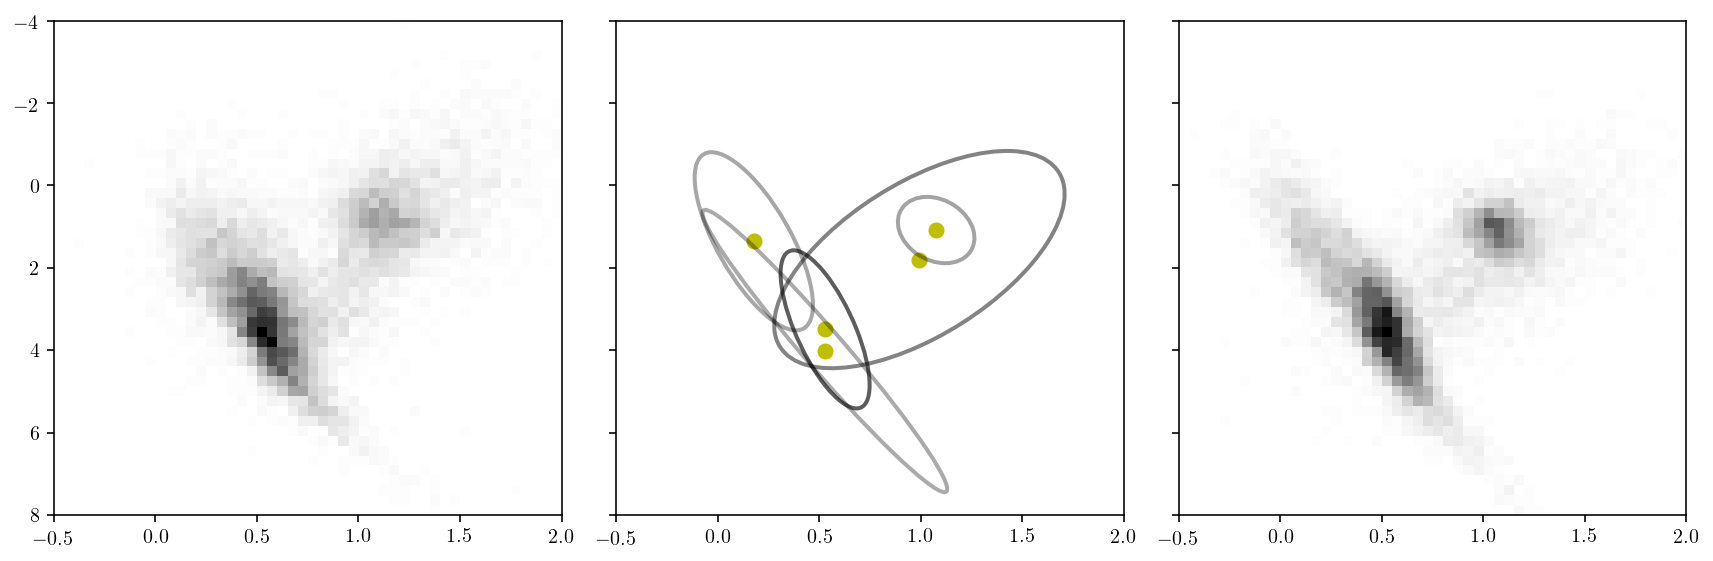

In [433]:
from matplotlib.patches import Ellipse

bincovars = np.zeros((2, 2, nbins))
for b in range(nbins):
    bincovars[:, :, b] = np.diag(binvars[b, :])
    bincovars[0, 1, b] = np.sqrt(np.prod(binvars[b, :])) * binrhos[b]
    bincovars[1, 0, b] = bincovars[0, 1, b]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

rr = [[-0.5, 2], [-4, 8]]

nbs = np.random.multinomial(nobj, binamps)
points = np.vstack([np.random.multivariate_normal(binmus[b, :], bincovars[:, :, b], size=nbs[b]) for b in range(nbins)]) 
axs[0].hist2d(obscolors[:].ravel(), obsabsmagG[:], 50, cmap="gray_r", range=rr)
#for i in np.random.choice(num, 100, replace=False):
#    binamps, binmus, binvars, binrhos = convert_params(paramvals[i, :])
#    axs[0].scatter(binmus[:, 1], binmus[:, 0], c='r')
#axs[0].scatter(centermus[:, 1], centermus[:, 0], c='b')
for b in range(nbins):
    axs[1].scatter(binmus[b, 1], binmus[b, 0], c='y')
    bincovar = np.matrix([[bincovars[0, 0, b], bincovars[1, 0, b]], 
                          [bincovars[0, 1, b], bincovars[1, 1, b]]])
    w, v = np.linalg.eig(bincovar[:, :])
    angle = 90. + 180/np.pi * 0.5 * np.arctan(2 * bincovar[0, 1] / (bincovar[1, 1] - bincovar[0, 0]))
    e = Ellipse(xy=binmus[b, :][np.array([1, 0])], 
                width=4*w[0]**0.5, height=4*w[1]**0.5, angle=angle, ec='k', fill=False)
    axs[1].add_artist(e)
    e.set_alpha(binamps[b]**0.5)

axs[2].hist2d(points[:, 1], points[:, 0], 50, cmap="gray_r", range=rr)
axs[0].set_ylim(rr[1][::-1])
axs[0].set_xlim(rr[0])
    
fig.tight_layout()